In [28]:
!pip install rerun-sdk
!pip install rerun-notebook
!pip install numpy
!pip install matplotlib


In [29]:
import numpy as np
import rerun as rr
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy import pi

## Geometry Primitives and Operations

In this section, we introduce the fundamental geometric primitives and operations used in our 2D robot localization and motion planning.

### Transform2d (SE(2))

`Transform2d` represents elements of the Special Euclidean group SE(2), which describes 2D rigid body transformations (translations and rotations).

$\mathbf{X} = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) & x \\
\sin(\theta) & \cos(\theta) & y \\
0 & 0 & 1
\end{bmatrix} \in SE(2)$

where:
- $(x, y)$ represents the translation
- $\theta$ represents the rotation angle

Key operations:
- Composition: $\mathbf{X}_1 \circ \mathbf{X}_2$ (implemented as `__mul__`)
- Inverse: $\mathbf{X}^{-1}$
- Logarithmic map: $\log: SE(2) \rightarrow se(2)$

### Twist2d (se(2))

`Twist2d` represents a robot relative position delta / velocity.  Mathematically it is known as the `Lie Algebra of SE(2)` and is denoted by $\xi = (v_x, v_y, \omega) \in se(2)$.  With the exponential map $\exp(\xi)$ you can convert Twists (se2) --> Transforms (SE2).  This operation is equivalent to what is colloquially known as "constant arc odometry" in FTC.

where:
- $(v_x, v_y)$ represents linear velocity
- $\omega$ represents angular velocity

The corresponding matrix representation is:

$\hat{\xi} = \begin{bmatrix}
0 & -\omega & v_x \\
\omega & 0 & v_y \\
0 & 0 & 0
\end{bmatrix}$

Key operation:
- Exponential map: $\exp: se(2) \rightarrow SE(2)$

### Vector2d

`Vector2d` represents 2D vectors, useful for various geometric calculations.

$\mathbf{v} = (x, y)$

Operations:
- Addition: $\mathbf{v}_1 + \mathbf{v}_2$
- Subtraction: $\mathbf{v}_1 - \mathbf{v}_2$
- Scalar multiplication: $c\mathbf{v}$
- Norm: $\|\mathbf{v}\|$

### Key Relationships

1. **Exponential Map** (Twist2d to Transform2d):
   $\exp(\xi) = \mathbf{X}$

2. **Logarithmic Map** (Transform2d to Twist2d):
   $\log(\mathbf{X}) = \xi$

These maps allow us to switch between the group SE(2) and its Lie algebra se(2), which is crucial for various robotic algorithms.

For a more rigorous explanation, refer to this video: [Lie theory for the roboticist](https://youtu.be/csolG83gCV8?si=qCsA8-9Z9A6nvBTI)

In [30]:
@dataclass
class Transform2d:
    """
    A 2D transformation on SE(2).  Represents a homogeneous transformation between two reference frames.

    Equivalent to Pose2D in Roadrunner and WPILib.

    Represents the functionality of the matrix:

    | cos(theta) -sin(theta) x |
    | sin(theta)  cos(theta) y |
    | 0           0          1 |


    Attributes:
    x: The x translation
    y: The y translation
    theta: The rotation in radians
    """
    x: float
    y: float
    theta: float

    def __mul__(self, other):
        """
        Composition of two transformations.  This is equivalent to the matrix product of the two transformations.

        SE(2) * SE(2) -> SE(2)
        """
        x = self.x + other.x * np.cos(self.theta) - other.y * np.sin(self.theta)
        y = self.y + other.x * np.sin(self.theta) + other.y * np.cos(self.theta)
        theta = wrap_angle(self.theta + other.theta)
        return Transform2d(x, y, theta)
    def __str__(self):
        return f"Pose2D(x: {self.x}, y: {self.y}, theta: {self.theta})"
    def inverse(self) -> 'Transform2d':
        """
        Inverse of a transform.  This is equivalent to the inverse of a matrix.

        SE(2) -> SE(2)
        """
        x = -self.x * np.cos(self.theta) - self.y * np.sin(self.theta)
        y = -self.x * np.sin(self.theta) + self.y * np.cos(self.theta)
        theta = wrap_angle(-self.theta)
        return Transform2d(x, y, theta)

    def log(self) -> 'Twist2d':
        """
        This is the logarithmic map from SE(2) to se(2).  It provides a transformation that represents a small change in pose.

        The idea is this can be used for discritizing transformations into the specific robot relative velocity needed to achieve that transformation.
        """
        theta = self.theta
        halfu = 0.5 * theta + snz(theta)
        v = halfu / np.tan(halfu)
        return Twist2d(
            v * self.x + halfu * self.y,
            -halfu * self.x + v * self.y,
            theta
        )

@dataclass
class Twist2d:
    """
    Represents a velocity / pose delta in 2D space.  This is equivalent to a Twist2d in Roadrunner and WPILib.

    Twists exist in a space tangent to that of SE(2) known as se(2).  This is the Lie algebra of SE(2).

    The exp() function provides a map from se(2) to SE(2).  This is the exponential map.
    """
    dx: float
    dy: float
    dtheta: float

    def exp(self):
        """
        This is the exponential map from se(2) to SE(2).  It provides a transformation that represents a small change in pose.

        se(2) -> SE(2)
        """
        angle = self.dtheta
        heading = self.dtheta
        u = angle + snz(angle)
        c = 1 - np.cos(u)
        s = np.sin(u)
        translation = Vector2d(
            (s * self.dx - c * self.dy) / u,
            (c * self.dx + s * self.dy) / u
        )
        return Transform2d(translation.x, translation.y, heading)

def snz(x: float) -> float:

    EPS = 1e-9
    return EPS if x >= 0.0 else -EPS

def wrap_angle(angle: float) -> float:
    while angle > pi:
        angle -= 2 * pi
    while angle < -pi:
        angle += 2 * pi
    return angle


@dataclass
class Vector2d:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
    def __add__(self, other: 'Vector2d') -> 'Vector2d':
        if type(other) == Vector2d:
            return Vector2d(self.x + other.x, self.y + other.y)
        else:
            raise TypeError("Unsupported type for addition with Vector2d")
    def __sub__(self, other: 'Vector2d') -> 'Vector2d':
        if type(other) == Vector2d:
            return Vector2d(self.x - other.x, self.y - other.y)
        else:
            raise TypeError("Unsupported type for subtraction with Vector2d")
    def __mul__(self, other: float) -> 'Vector2d':
        return Vector2d(self.x * other, self.y * other)
    def __truediv__(self, other: float) -> 'Vector2d':
        return Vector2d(self.x / other, self.y / other)
    def norm(self) -> float:
        return (self.x ** 2 + self.y ** 2) ** 0.5

In [31]:
noise_normal = 0.011
@dataclass
class SimRobot:
    """
    Simulated robot with exponential map motion model.
    """
    true_pose: Transform2d
    estimated_pose: Transform2d
    true_pos_history: list[Transform2d]
    estimated_pos_history: list[Transform2d]

    def step(self, twist: Twist2d, process_noise: bool) -> Twist2d:
        """
        steps the robot simulation

        twist returned is the observed twist by the robots odometry.
        """

        self.true_pose = self.true_pose * twist.exp()

        twist_noise = Twist2d(0.0, 0.0, 0.0)
        if process_noise:
            twist_noise = Twist2d(
                np.random.normal(0, noise_normal),
                np.random.normal(0, noise_normal),
                np.random.normal(0, noise_normal)
            )

        twist = Twist2d(
            twist.dx + twist_noise.dx,
            twist.dy + twist_noise.dy,
            twist.dtheta + twist_noise.dtheta
        )

        self.estimated_pose = self.estimated_pose * twist.exp()
        self.true_pos_history.append(self.true_pose)
        self.estimated_pos_history.append(self.estimated_pose)

        return twist

@dataclass
class NaiveRobot:
    """
    Simulated robot with naive euler integration motion model.
    """
    def __init__(self, true_pose: Transform2d):
        self.true_pose = true_pose
        self.estimated_pose = true_pose
        self.true_pos_history = [true_pose]
        self.estimated_pos_history = [true_pose]

    def step(self, twist: Twist2d):
        tf = Transform2d(twist.dx, twist.dy, twist.dtheta)
        self.true_pose = self.true_pose * tf
        self.estimated_pose = self.estimated_pose * tf
        self.true_pos_history.append(self.true_pose)
        self.estimated_pos_history.append(self.estimated_pose)


## Log map explained

In this example we simulate the robot for a single time stamp.  We want the robot to travel perfectly along its diagonal to reach the position (1,1,45 deg) after 1 second.  

To accomplish this we need to account for the fact that as a robot drives it drives in an arc in its given reference frame.  The log map finds the relative change in position needed to achieve the ideal arc to reach the desired pose.  

In [32]:
dt = 1.0 # s
vx = 1.0 # m/s
vy = 1.0 # m/s
omega = np.deg2rad(45) # rad/s

# our desired position change during this time step
velocity_reference = Transform2d(vx * dt, vy * dt, omega * dt)

# convert this to a twist
twist_reference = velocity_reference.log()
print(twist_reference)

# create a robot at the origin
robot = SimRobot(Transform2d(0, 0, 0), Transform2d(0, 0, 0), [], [])
# step the robot
robot.step(twist_reference, process_noise=True)
# observe the robot should be at our desired position
print(robot)

Twist2d(dx=1.3407585313999406, dy=0.5553603660024924, dtheta=0.7853981633974483)
SimRobot(true_pose=Transform2d(x=1.0000000005661327, y=0.999999999566133, theta=0.7853981633974483), estimated_pose=Transform2d(x=0.9969630274876663, y=1.0085412633922866, theta=0.8057951355273528), true_pos_history=[Transform2d(x=1.0000000005661327, y=0.999999999566133, theta=0.7853981633974483)], estimated_pos_history=[Transform2d(x=0.9969630274876663, y=1.0085412633922866, theta=0.8057951355273528)])


In [33]:
import random


def add_3d_path_to_rerun(path, topic: str, color = None, sample_percent = 1.0):
    z = 0.1

    if sample_percent < 1.0:
        path = path[::int(1/sample_percent)]

    if type(path[0]) == tuple:
        # convert to 3d point with z
        path_points = [[pose[0], pose[1], z] for pose in path]
    else:
        path_points = [[pose.x, pose.y, z] for pose in path]
    if color is not None:
        path_line = rr.Points3D(path_points, colors=[color], radii=[0.025])
    else:
        path_line = rr.Points3D(path_points, colors=[random_bright_color()], radii=[0.025])
    rr.log(topic + "3d", path_line)

def random_bright_color(floor = 120):
    return [random.randint(floor, 255), random.randint(floor, 255), random.randint(floor, 255)]

def add_path_to_matplotlib(path, label):
    plt.plot([pose.x for pose in path], [pose.y for pose in path], label=label)
    plt.legend()


def log_robot_pose_rerun(pose: Transform2d, topic: str, time: float, colors = [255, 0, 0]):
    rr.set_time_seconds("/log_time", time)
    box = rr.Boxes3D(
        centers = [[pose.x, pose.y, 0.1]],
        half_sizes = [[0.1, 0.1, 0.1]],
        rotations = rr.RotationAxisAngle(axis=[0, 0, 1], angle=pose.theta),
        colors = colors
    )
    rr.log(topic, box)


## Simulated Robot trajectory

We can simulate a robot with a given reference trajectory and compare the naive euler integration to the actual SE2 motion. As we can see the naive euler integration diverges fairly quickly from the actual SE2 motion.

This is why we use the exponential map to update our pose in deadreckoning.  You can see this in roadrunner here: https://github.com/acmerobotics/road-runner-quickstart/blob/a75cfbaa46fbc901c9f2dae34295058ee1b84649/TeamCode/src/main/java/org/firstinspires/ftc/teamcode/MecanumDrive.java#L444

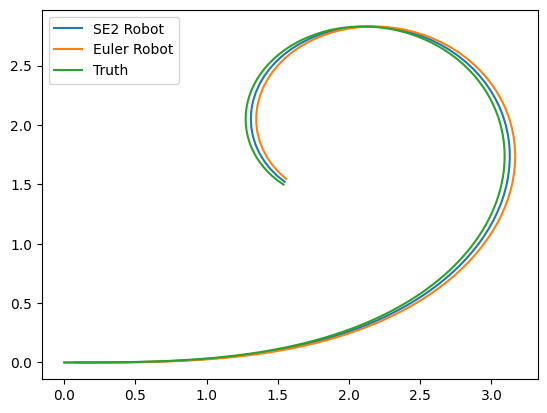

0.02680138714087079
0.024379884455412382


In [34]:
def get_twist(t: float, dt: float)-> Twist2d:
    x = 0.5 * dt
    y = 0.0 * dt
    theta = t * 0.05 * dt
    return Twist2d(x, y, theta)


rr.init("compare twist exponential trajectory to naive euler integration.")

duration = 15.0 # s
dt = 0.15 # s
dt_accurate = 0.0025 # s

# create a robot at the origin
robot = SimRobot(Transform2d(0, 0, 0), Transform2d(0, 0, 0), [], [])
naive_robot = NaiveRobot(Transform2d(0, 0, 0))
low_dt_robot = NaiveRobot(Transform2d(0, 0, 0))

for t in np.arange(0, duration, dt_accurate):
    twist = get_twist(t, dt_accurate)
    low_dt_robot.step(twist)


for t in np.arange(0, duration, dt):
    twist = get_twist(t, dt)
    robot.step(twist, process_noise=False)
    naive_robot.step(twist)

add_path_to_matplotlib(robot.estimated_pos_history, "SE2 Robot")
add_path_to_matplotlib(naive_robot.true_pos_history, "Euler Robot")
add_path_to_matplotlib(low_dt_robot.true_pos_history, "Truth")
plt.show()

end_pose_distance_euler = np.sqrt((robot.true_pos_history[-1].x - naive_robot.true_pos_history[-1].x)**2 + (robot.true_pos_history[-1].y - naive_robot.true_pos_history[-1].y)**2)
end_pose_distance_low_dt = np.sqrt((robot.true_pos_history[-1].x - low_dt_robot.true_pos_history[-1].x)**2 + (robot.true_pos_history[-1].y - low_dt_robot.true_pos_history[-1].y)**2)
print(end_pose_distance_euler)
print(end_pose_distance_low_dt)

## Odometry Drift

While we can see that the SE2 exponential map improves our accuracy, we can see that our estimate is going to drift once we enable process noise.  While encoders aren't really 'noisy' they do have some random amounts of error from slip, wheels not being perfectly sized, and other process issues.  We will simulate this by adding a normal distribution to our twist input.

We can see that even with this small amount of noise our estimate is going to drift.    

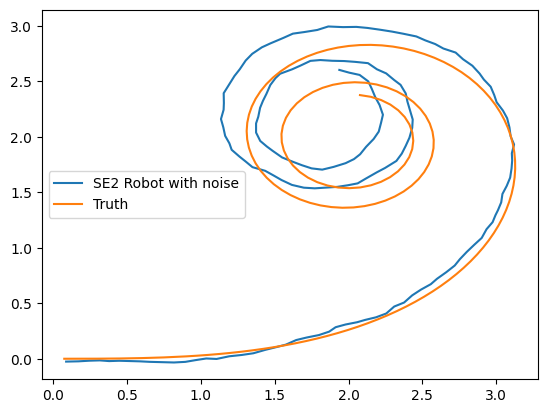

In [35]:
duration = 25.0 # s
dt = 0.15 # s

# create a robot at the origin
robot = SimRobot(Transform2d(0, 0, 0), Transform2d(0, 0, 0), [], [])


for t in np.arange(0, duration, dt):
    twist = get_twist(t, dt)
    robot.step(twist, process_noise=True)

add_path_to_matplotlib(robot.estimated_pos_history, "SE2 Robot with noise")
add_path_to_matplotlib(robot.true_pos_history, "Truth")
plt.show()

## Simulating April Tag Measurements

We can assume that you have code written that is able to estimate your robot pose using an April Tags though it may be too noisy to properly use.  For this example we will simulate april tags by adding noise to the sim's true robot pose.  This simulates the gaussian distribution we should expect from real april tag measurements.


In [36]:
def get_tag_measurement(pose: Transform2d)-> Transform2d:
    noise_normal = 0.10
    return Transform2d(pose.x + np.random.normal(0, noise_normal), pose.y + np.random.normal(0, noise_normal), pose.theta + np.random.normal(0, noise_normal))

## Key

In the visualization below green represents the ground truth state, blue represents the pose estimated by the april tags and red represents the odometry data.

In [37]:
# simulate tag estimate vs odom vs ground truth
from time import sleep
def get_twist(t: float, dt: float)-> Twist2d:
    x = 0.5 * dt
    y = 0.0 * dt
    theta = np.cos(t) * dt
    return Twist2d(x, y, theta)

rr.init("tag estimate vs odom vs ground truth")

duration = 25.0 # s
dt = 0.05 # s

# create a robot at the origin
robot = SimRobot(Transform2d(0, 0, 0), Transform2d(0, 0, 0), [], [])
tag_measurements = []
for t in np.arange(0, duration, dt):
    twist = get_twist(t, dt)
    robot.step(twist, process_noise=True)
    tag_measurements.append(get_tag_measurement(robot.true_pose))

# put these here so the paths draw first.
add_3d_path_to_rerun(robot.estimated_pos_history, "tag_estimate", color = [255, 0, 0])
add_3d_path_to_rerun(robot.true_pos_history, "truth", color = [0, 255, 0])
add_3d_path_to_rerun(tag_measurements, "tag_measurements", color = [0, 0, 255])
time = 0.0
for i in range(len(tag_measurements)):
    time += dt
    log_robot_pose_rerun(robot.true_pos_history[i], "truth", time, colors = [0, 255, 0])
    log_robot_pose_rerun(robot.estimated_pos_history[i], "tag_estimate", time, colors = [255, 0, 0])
    log_robot_pose_rerun(tag_measurements[i], "tag_measurements", time, colors = [0, 0, 255])
    add_3d_path_to_rerun(robot.estimated_pos_history, "tag_estimate", color = [255, 0, 0])
    add_3d_path_to_rerun(robot.true_pos_history, "truth", color = [0, 255, 0])
    add_3d_path_to_rerun(tag_measurements, "tag_measurements", color = [0, 0, 255])

rr.notebook_show()

Viewer()

## Robot sensor fusion with Static Kalman Filter (Luengberger Observer).

For a robot moving in a 2D plane, we can represent its pose using the Special Euclidean group SE(2), which accurately captures the structure of 2D rigid body motions.

While the exponential map is more accurate than euler integration there is still process noise which accumulates and leads to drift.  We also have external references such as april tags which are absolute to our global reference frame but also have noise which prevents us from using them directly, additionally there may be situations where the tags are not available for measurements such as if they are occluded by a game element.  Our goal is to create an algorithm that estimates the true robot pose using the external reference (long term accuracy) and also corrects for the drift from the odometry (high frequency update rate, always available).

## Kalman Filter State Extrapolation

The first step of the kalman filter is to use the motion model to predict the robots pose at the next timestep.  This is equivalent to multiplying the previous pose by the exponential map of the twist. This is exactly what we did before in the SimRobot class:

$\mathbf{X}_n = \mathbf{X}_{n-1} \cdot \exp(\hat{\xi})$

where:
- $\mathbf{X}_n$ is the new state
- $\mathbf{X}_{n-1}$ is the previous state
- $\exp(\cdot)$ is the exponential map
- $\hat{\xi} \in se(2)$ is the estimated twist from odometry


## Kalman Filter State Correction

Next we want to obtain a new external reference measurement (z) from april tags and use that to correct our state estimate.  
This is done with the following equation:
$\mathbf{X}_{\text{updated}} = \mathbf{X}_{\text{n}} + K \times (\mathbf{Z} -  \mathbf{X}_{\text{n}})$

where:
- $\mathbf{X}_{\text{updated}}$ is the corrected state estimate
- $\mathbf{X}_{\text{predicted}}$ is the predicted state
- $\mathbf{K}$ is the kalman gain vector (each element is on the domain 0 < x < 1)
- $\mathbf{Z}$ is the measured pose from an april tag or other external reference without drift.

A good intuition for what is happening here is at each time stamp we are projecting our state (just like traditional odometry) but we are "pulling" the estimated pose towards the true pose.  Since we assume the tag measurements follow a gaussian distribution around the robots state this repeated sampling theoretically will converge to the true robot pose with time and the state projection ensures minimum phase lag compared to simpler recursive filters like low pass and moving average filters.

In [38]:
gain_x = 0.08
gain_y = 0.08
gain_theta = 0.1

def correct_state(estimate_prior: Transform2d, tag_measurement: Transform2d) -> Transform2d:
    correction = Transform2d(tag_measurement.x - estimate_prior.x, tag_measurement.y - estimate_prior.y, wrap_angle(tag_measurement.theta - estimate_prior.theta))
    # element wise product by our gain vector.
    correction = Transform2d(gain_x * correction.x, gain_y * correction.y, wrap_angle(gain_theta * correction.theta))
    return Transform2d(estimate_prior.x + correction.x, estimate_prior.y + correction.y, wrap_angle(estimate_prior.theta + correction.theta))

## Key update

Yellow represents the kalman filter estimate.

In [39]:
# simulate tag estimate vs odom vs ground truth
def get_twist(t: float, dt: float)-> Twist2d:
    x = 0.5 * dt
    y = 0.0 * dt
    theta = np.cos(t) * dt
    return Twist2d(x, y, theta)


duration = 25.0 # s
dt = 0.05 # s

# create a robot at the origin
robot = SimRobot(Transform2d(0, 0, 0), Transform2d(0, 0, 0), [], [])
tag_measurements = []
kalman_estimated = []
# ideal situation where we know the initial pose, this is true enough for FTC. a "true" kalman filter can account better for less well defined initial poses.
kalman_estimate = Transform2d(0,0,0)
for t in np.arange(0, duration, dt):
    twist = get_twist(t, dt)
    observed_twist = robot.step(twist, process_noise=True)
    tag_measurement = get_tag_measurement(robot.true_pose)
    tag_measurements.append(tag_measurement)

    # kalman filter

    # project state forward
    kalman_estimate = kalman_estimate * observed_twist.exp()
    # correct with tag
    kalman_estimate = correct_state(kalman_estimate, tag_measurement)
    kalman_estimated.append(kalman_estimate)

rr.init("tag estimate vs odom vs ground truth")

# put these here so the paths draw first.
add_3d_path_to_rerun(robot.estimated_pos_history, "tag_estimate", color = [255, 0, 0])
add_3d_path_to_rerun(robot.true_pos_history, "truth", color = [0, 255, 0])
add_3d_path_to_rerun(tag_measurements, "tag_measurements", color = [0, 0, 255])
add_3d_path_to_rerun(kalman_estimated, "kalman_estimate", color = [255, 255, 0])
time = 0.0
for i in range(len(tag_measurements)):
    time += dt
    log_robot_pose_rerun(robot.true_pos_history[i], "truth", time, colors = [0, 255, 0])
    log_robot_pose_rerun(robot.estimated_pos_history[i], "tag_estimate", time, colors = [255, 0, 0])
    log_robot_pose_rerun(tag_measurements[i], "tag_measurements", time, colors = [0, 0, 255])
    add_3d_path_to_rerun(robot.estimated_pos_history, "tag_estimate", color = [255, 0, 0])
    add_3d_path_to_rerun(robot.true_pos_history, "truth", color = [0, 255, 0])
    add_3d_path_to_rerun(tag_measurements, "tag_measurements", color = [0, 0, 255])
    add_3d_path_to_rerun(kalman_estimated, "kalman_estimate", color = [255, 255, 0])
    log_robot_pose_rerun(kalman_estimated[i], "kalman_estimate", time, colors = [255, 255, 0])



rr.notebook_show()



Viewer()